In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import ScalarFormatter
from scipy.stats import linregress
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd
import pickle
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
from scipy.optimize import curve_fit, least_squares
from matplotlib.colors import LinearSegmentedColormap

from matplotlib.colors import Normalize
import matplotlib.ticker as ticker
from matplotlib.patches import Rectangle
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d


In [10]:
def get_all_pkl_files(base_dir):
    pkl_files = []
    for root, dirs, files in os.walk(base_dir):
        if "_new" in root:
            for file in files:
                if file.endswith(".pkl"):
                    pkl_files.append(os.path.join(root, file))
    return pkl_files

In [11]:
base_directory = "/home/shichenliu/Dropbox/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_1/0104PIV_data_0104/"


In [12]:
def get_all_pkl_files(base_dir):
    pkl_files = []
    for root, dirs, files in os.walk(base_dir):
        if "_finer" in root:
            for file in files:
                if file.endswith(".pkl"):
                    pkl_files.append(os.path.join(root, file))
    return pkl_files

In [13]:
def compute_correlation(velocity_data, frame_rate, start_frame=90, end_frame=110):
    # Get the shape of the velocity field from the first frame
    first_frame = list(velocity_data.keys())[0]
    UX, UY = velocity_data[first_frame]
    size_y, size_x = UX.shape

    # Select middle ±3 grid points in y-direction (equivalent to ±100 pixels)
    mid_y = size_y // 2
    start_y = max(mid_y - 4, 0)
    end_y = min(mid_y + 4, size_y)

    # Ignore the leftmost 10 vectors and the rightmost 3 vectors
    start_x = 10
    end_x = size_x - 5  # Discard the rightmost 3 vectors

    # Compute mean velocity (ignoring the leftmost 10 vectors and the rightmost 3 vectors)
    mean_UX = np.mean([velocity_data[t][0][start_y:end_y, start_x:end_x] for t in range(start_frame, end_frame)])
    mean_UY = np.mean([velocity_data[t][1][start_y:end_y, start_x:end_x] for t in range(start_frame, end_frame)])

    correlations = []

    for frame in range(start_frame, end_frame):
        UX, UY = velocity_data[frame]
        frame_correlation = []
        
        # Use the reference vector (last vector before the excluded rightmost 3 vectors)
        ux_fluct_right = UX[start_y:end_y, end_x - 1] - mean_UX
        uy_fluct_right = UY[start_y:end_y, end_x - 1] - mean_UY
        
        for x in range(end_x - 1, start_x - 1, -1):  # Start from the new reference point and move left
            ux_fluct_current = UX[start_y:end_y, x] - mean_UX
            uy_fluct_current = UY[start_y:end_y, x] - mean_UY

            numerator = np.mean(ux_fluct_right * ux_fluct_current + uy_fluct_right * uy_fluct_current)
            denominator = np.sqrt(np.mean(ux_fluct_right**2 + uy_fluct_right**2) * 
                                  np.mean(ux_fluct_current**2 + uy_fluct_current**2))
            
            correlation = numerator / denominator
            frame_correlation.append(correlation)
        
        correlations.append(frame_correlation)

    # Average over frames
    avg_correlation = np.mean(correlations, axis=0)

    return avg_correlation


/tmp/ipykernel_3486358/3453263754.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


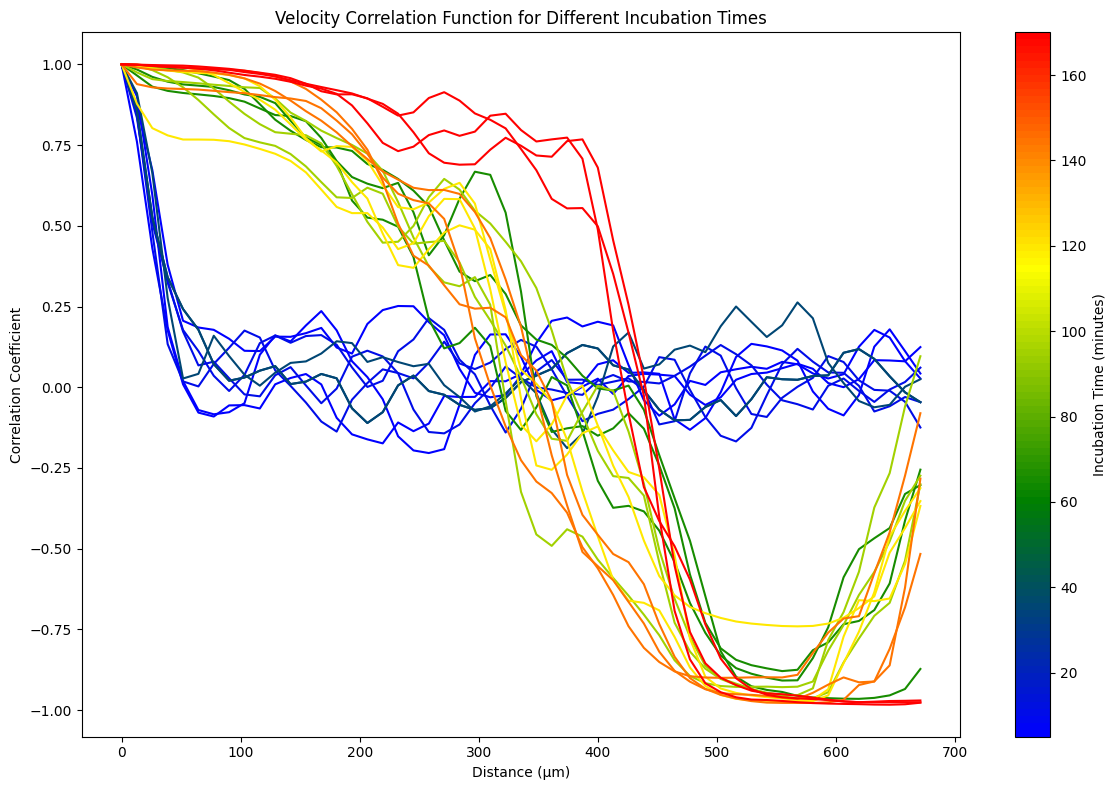

Overall max correlation: 1.0
Overall min correlation: -0.9830366969108582
Overall mean correlation: 0.08560697734355927


In [14]:
# Create a custom colormap
colors = ['blue', 'green', 'yellow', 'red']
n_bins = 100
cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

plt.figure(figsize=(12, 8))

# Collect incubation times and correlations
data = []

# Process each folder
for folder in os.listdir(base_directory):
    if folder.endswith('_finer'):
        folder_path = os.path.join(base_directory, folder)
        
        # Extract incubation time
        incubation_time = folder.split('_')[0]
        if incubation_time == '5':
            incubation_time = 5  # Handle the '5_min' case
        else:
            incubation_time = int(incubation_time)
        
        # Find the pickle file
        pkl_file = None
        for file in os.listdir(folder_path):
            if file.endswith(".pkl"):
                pkl_file = os.path.join(folder_path, file)
                break
        
        if pkl_file is not None:
            frame_rate = 0.1  # frames per second

            with open(pkl_file, 'rb') as f:
                velocity_data = pickle.load(f)
                correlation = compute_correlation(velocity_data, frame_rate)
            
            data.append((incubation_time, correlation))

# Sort the data by incubation time
data.sort(key=lambda x: x[0])

# Separate sorted times and correlations
incubation_times, all_correlations = zip(*data)

# Plot the correlations
for time, correlation in zip(incubation_times, all_correlations):
    plt.plot(np.arange(len(correlation)) * 0.43 * 30, correlation, 
             color=cmap((time - min(incubation_times)) / (max(incubation_times) - min(incubation_times))))

plt.xlabel('Distance (µm)')
plt.ylabel('Correlation Coefficient')
plt.title('Velocity Correlation Function for Different Incubation Times')

# Create a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(incubation_times), vmax=max(incubation_times)))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Incubation Time (minutes)')

plt.tight_layout()
plt.show()

# Print some overall statistics
all_correlations_flat = [item for sublist in all_correlations for item in sublist]
print(f"Overall max correlation: {np.max(all_correlations_flat)}")
print(f"Overall min correlation: {np.min(all_correlations_flat)}")
print(f"Overall mean correlation: {np.mean(all_correlations_flat)}")

/tmp/ipykernel_3486358/1053923695.py:39: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


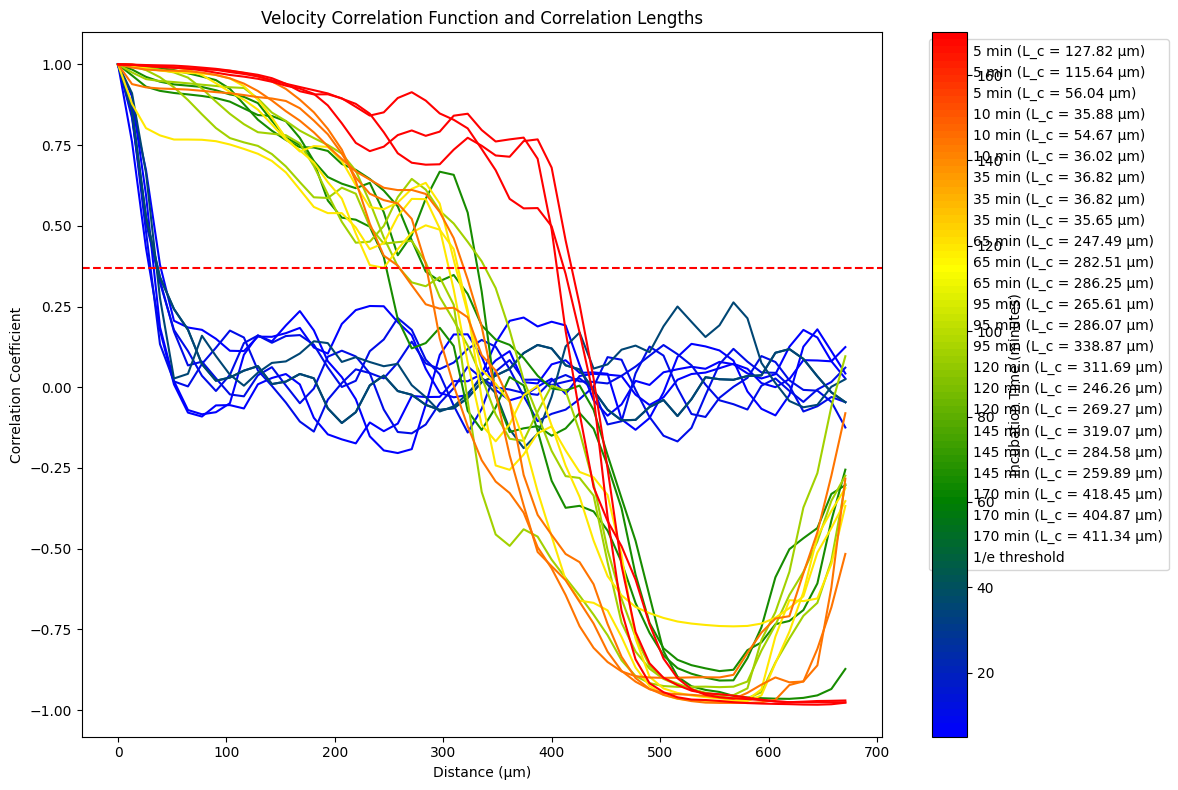

Incubation time: 5 min, Correlation length: 127.82 µm
Incubation time: 5 min, Correlation length: 115.64 µm
Incubation time: 5 min, Correlation length: 56.04 µm
Incubation time: 10 min, Correlation length: 35.88 µm
Incubation time: 10 min, Correlation length: 54.67 µm
Incubation time: 10 min, Correlation length: 36.02 µm
Incubation time: 35 min, Correlation length: 36.82 µm
Incubation time: 35 min, Correlation length: 36.82 µm
Incubation time: 35 min, Correlation length: 35.65 µm
Incubation time: 65 min, Correlation length: 247.49 µm
Incubation time: 65 min, Correlation length: 282.51 µm
Incubation time: 65 min, Correlation length: 286.25 µm
Incubation time: 95 min, Correlation length: 265.61 µm
Incubation time: 95 min, Correlation length: 286.07 µm
Incubation time: 95 min, Correlation length: 338.87 µm
Incubation time: 120 min, Correlation length: 311.69 µm
Incubation time: 120 min, Correlation length: 246.26 µm
Incubation time: 120 min, Correlation length: 269.27 µm
Incubation time: 

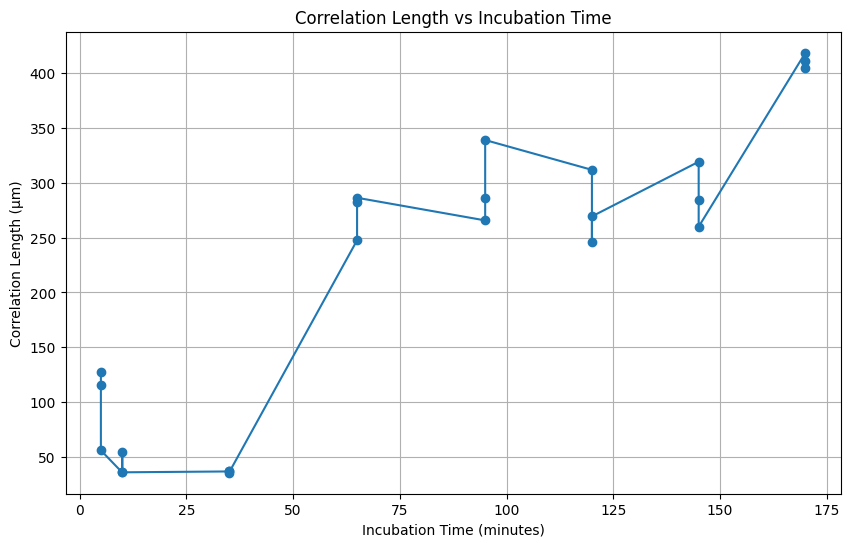

In [15]:
def calculate_correlation_length(distances, correlation, threshold=1/np.e):
    # Create an interpolation function
    f = interp1d(correlation, distances, bounds_error=False, fill_value="extrapolate")
    
    # Find the correlation length
    correlation_length = f(threshold)
    
    return correlation_length

# After your existing code, add:

plt.figure(figsize=(12, 8))

correlation_lengths = []

for time, correlation in zip(incubation_times, all_correlations):
    distances = np.arange(len(correlation)) * 0.43 * 30  # µm
    
    # Calculate correlation length
    corr_length = calculate_correlation_length(distances, correlation)
    correlation_lengths.append(corr_length)
    
    # Plot the correlation
    plt.plot(distances, correlation, 
             color=cmap((time - min(incubation_times)) / (max(incubation_times) - min(incubation_times))),
             label=f'{time} min (L_c = {corr_length:.2f} µm)')

plt.xlabel('Distance (µm)')
plt.ylabel('Correlation Coefficient')
plt.title('Velocity Correlation Function and Correlation Lengths')
plt.axhline(y=1/np.e, color='r', linestyle='--', label='1/e threshold')

# Create a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(incubation_times), vmax=max(incubation_times)))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Incubation Time (minutes)')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print correlation lengths
for time, length in zip(incubation_times, correlation_lengths):
    print(f"Incubation time: {time} min, Correlation length: {length:.2f} µm")

# Plot correlation length vs incubation time
plt.figure(figsize=(10, 6))
plt.plot(incubation_times, correlation_lengths, 'o-')
plt.xlabel('Incubation Time (minutes)')
plt.ylabel('Correlation Length (µm)')
plt.title('Correlation Length vs Incubation Time')
plt.grid(True)
plt.show()

/tmp/ipykernel_3486358/3139771060.py:55: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Incubation Time (minutes)')


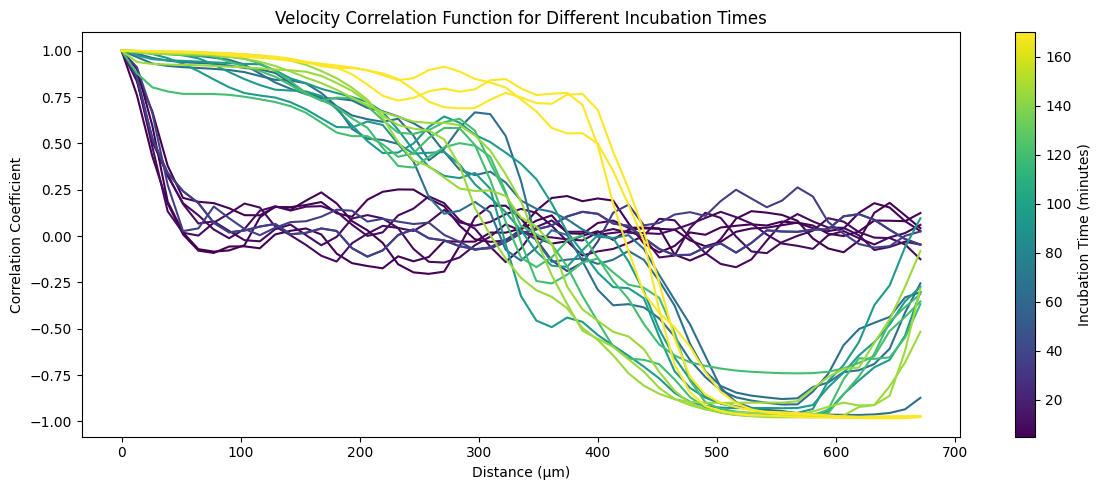

Incubation time: 5 min, Correlation length: 28.99 µm
Incubation time: 5 min, Correlation length: 32.98 µm
Incubation time: 5 min, Correlation length: 39.55 µm
Incubation time: 10 min, Correlation length: 35.88 µm
Incubation time: 10 min, Correlation length: 30.03 µm
Incubation time: 10 min, Correlation length: 36.02 µm
Incubation time: 35 min, Correlation length: 36.82 µm
Incubation time: 35 min, Correlation length: 36.82 µm
Incubation time: 35 min, Correlation length: 35.65 µm
Incubation time: 65 min, Correlation length: 247.49 µm
Incubation time: 65 min, Correlation length: 282.51 µm
Incubation time: 65 min, Correlation length: 331.63 µm
Incubation time: 95 min, Correlation length: 259.71 µm
Incubation time: 95 min, Correlation length: 286.07 µm
Incubation time: 95 min, Correlation length: 338.87 µm
Incubation time: 120 min, Correlation length: 311.69 µm
Incubation time: 120 min, Correlation length: 313.70 µm
Incubation time: 120 min, Correlation length: 305.15 µm
Incubation time: 14

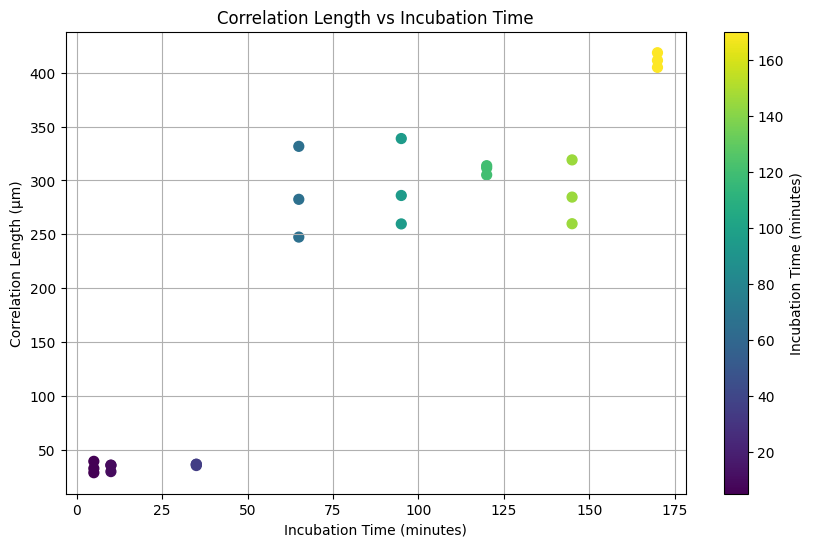

In [16]:
def calculate_correlation_length(distances, correlation, threshold=1/np.e, min_threshold=0.1):
    below_threshold = np.where(correlation < threshold)[0]
    if len(below_threshold) > 0:
        index = below_threshold[0]
        if index > 0:
            x = [distances[index-1], distances[index]]
            y = [correlation[index-1], correlation[index]]
            f = interp1d(y, x)
            return float(f(threshold))
    
    below_min = np.where(correlation < min_threshold)[0]
    if len(below_min) > 0:
        return distances[below_min[0]]
    
    return distances[-1]

# Convert incubation_times to a list if it's not already
incubation_times = list(incubation_times)

# Create a list of tuples (incubation_time, correlation_data)
data_pairs = list(zip(incubation_times, all_correlations))

# Sort the list based on incubation times
sorted_data = sorted(data_pairs, key=lambda x: x[0])

# Unzip the sorted data
incubation_times, all_correlations = zip(*sorted_data)

# Set up the colormap
norm = Normalize(vmin=min(incubation_times), vmax=max(incubation_times))
cmap = plt.get_cmap('viridis')

# Plotting the Velocity Correlation Function
plt.figure(figsize=(12, 5))

correlation_lengths = []

for time, correlation in zip(incubation_times, all_correlations):
    distances = np.arange(len(correlation)) * 0.43 * 30  # µm
    
    corr_length = calculate_correlation_length(distances, correlation, min_threshold=0.1)
    correlation_lengths.append(corr_length)
    
    color = cmap(norm(time))
    plt.plot(distances, correlation, color=color, label=f'{time} min (L_c = {corr_length:.2f} µm)')

plt.xlabel('Distance (µm)')
plt.ylabel('Correlation Coefficient')
plt.title('Velocity Correlation Function for Different Incubation Times')
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Incubation Time (minutes)')
plt.tight_layout()
plt.show()

# Print correlation lengths
for time, length in zip(incubation_times, correlation_lengths):
    print(f"Incubation time: {time} min, Correlation length: {length:.2f} µm")

# ... (previous code remains the same)

# Plotting Correlation Length vs Incubation Time
plt.figure(figsize=(10, 6))
scatter = plt.scatter(incubation_times, correlation_lengths, c=incubation_times, cmap='viridis', norm=norm, s=50)
plt.colorbar(scatter, label='Incubation Time (minutes)')
plt.xlabel('Incubation Time (minutes)')
plt.ylabel('Correlation Length (µm)')
plt.title('Correlation Length vs Incubation Time')
plt.grid(True)
plt.show()

In [17]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.ticker as ticker

def set_plot_style():
    plt.style.use('default')


    plt.rc('font', size=24)          # controls default text sizes
    plt.rc('axes', titlesize=28)    # fontsize of the axes title
    plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
    plt.rc('legend', fontsize=22)    # legend fontsize
    plt.rc('figure', titlesize=22)   # fontsize of the figure title

    return {
        'FIGURE_WIDTH': 9,
        'FIGURE_HEIGHT': 5,
        'SCATTER_SIZE': 50,
        'SCATTER_ALPHA': 0.7,
        'LINE_WIDTH': 2  # Added this line
    }

/tmp/ipykernel_3486358/2664801143.py:34: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


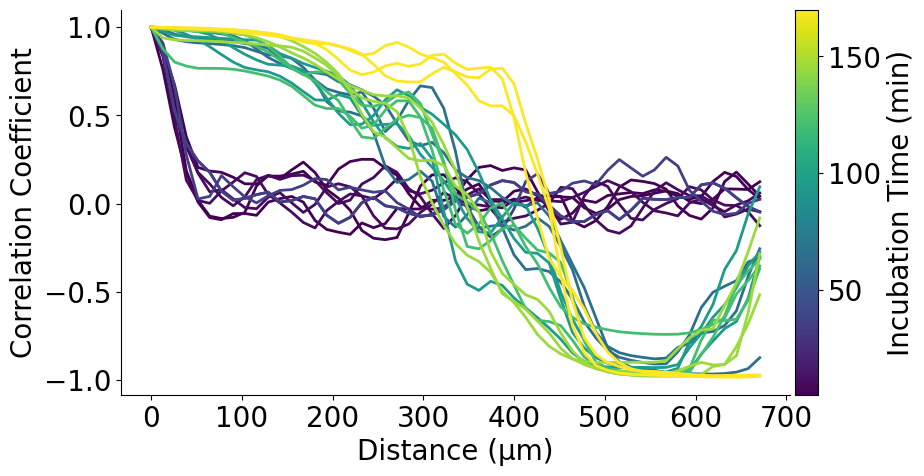

/tmp/ipykernel_3486358/2664801143.py:72: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


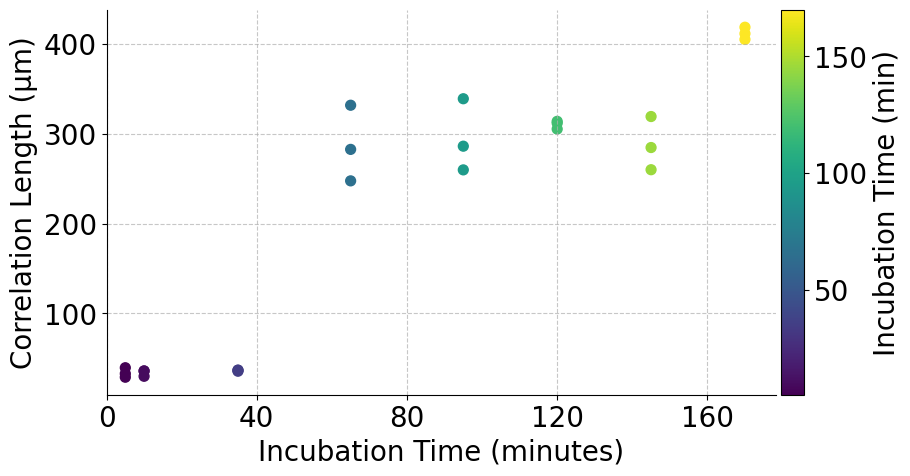

In [18]:
#Get style parameters
style_params = set_plot_style()

# Velocity Correlation Function Plot
fig = plt.figure(figsize=(style_params['FIGURE_WIDTH'], style_params['FIGURE_HEIGHT']))
gs = fig.add_gridspec(1, 25)  # Create a 1x25 grid
ax = fig.add_subplot(gs[0, :24])  # Main plot takes 24/25 of the width
cax = fig.add_subplot(gs[0, 24])  # Colorbar axes takes 1/25 of the width

correlation_lengths = []

for time, correlation in zip(incubation_times, all_correlations):
    distances = np.arange(len(correlation)) * 0.43 * 30  # µm
    
    corr_length = calculate_correlation_length(distances, correlation, min_threshold=0.1)
    correlation_lengths.append(corr_length)
    
    color = cmap(norm(time))
    ax.plot(distances, correlation, color=color, linewidth=style_params['LINE_WIDTH'])

ax.set_xlabel('Distance (µm)')
ax.set_ylabel('Correlation Coefficient')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label('Incubation Time (min)')

plt.tight_layout()

plt.show()

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import Normalize

# Correlation Length vs Incubation Time Plot
fig = plt.figure(figsize=(style_params['FIGURE_WIDTH'], style_params['FIGURE_HEIGHT']))
gs = fig.add_gridspec(1, 25)  # Create a 1x25 grid
ax = fig.add_subplot(gs[0, :24])  # Main plot takes 24/25 of the width
cax = fig.add_subplot(gs[0, 24])  # Colorbar axes takes 1/25 of the width

# Convert frame numbers to minutes
incubation_times_minutes = [time for time in incubation_times]

scatter = ax.scatter(incubation_times_minutes, correlation_lengths, 
                     c=incubation_times_minutes, cmap='viridis', 
                     norm=Normalize(vmin=min(incubation_times_minutes), vmax=max(incubation_times_minutes)), 
                     s=style_params['SCATTER_SIZE'])

ax.set_xlabel('Incubation Time (minutes)')
ax.set_ylabel('Correlation Length (µm)')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, linestyle='--', alpha=0.7)

# Colorbar
cbar = fig.colorbar(scatter, cax=cax)
cbar.set_label('Incubation Time (min)')

# Set x-axis to start at 0 and show fewer ticks
ax.set_xlim(left=0)
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True, nbins=5))

plt.tight_layout()

plt.show()



/tmp/ipykernel_3486358/3222590491.py:55: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Incubation Time (minutes)')


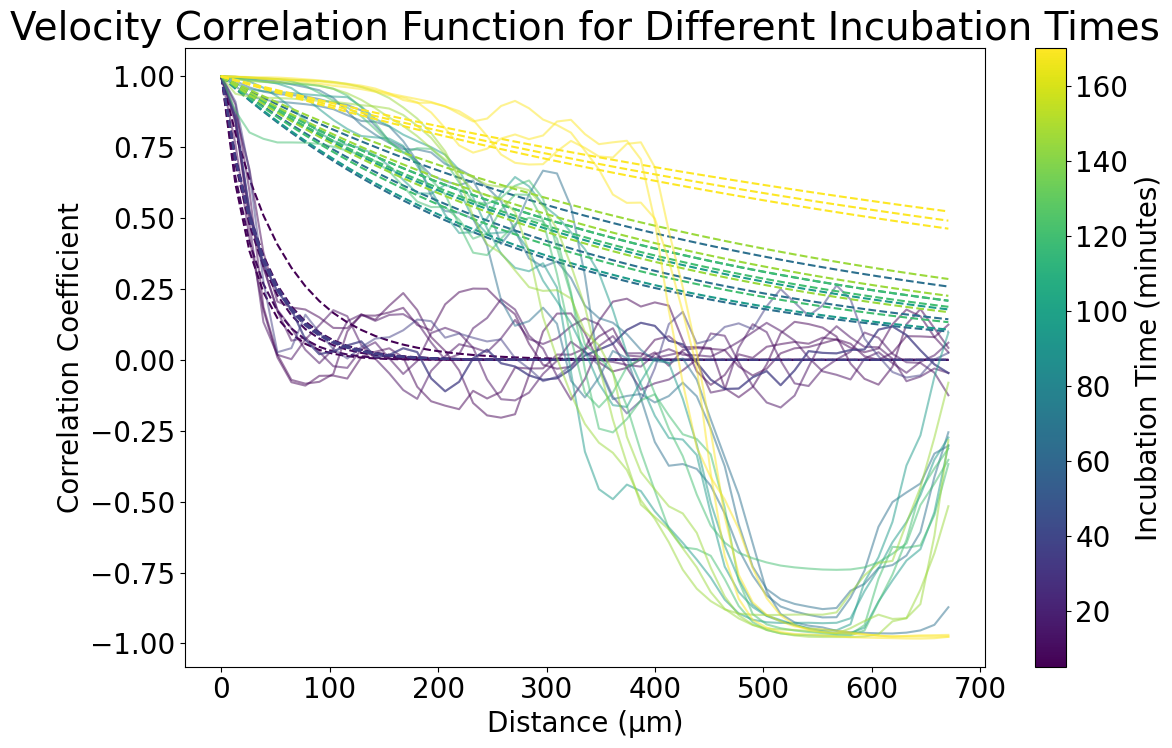

Incubation time: 5 min, Correlation length: 26.96 µm
Incubation time: 5 min, Correlation length: 37.63 µm
Incubation time: 5 min, Correlation length: 57.44 µm
Incubation time: 10 min, Correlation length: 38.69 µm
Incubation time: 10 min, Correlation length: 29.36 µm
Incubation time: 10 min, Correlation length: 34.89 µm
Incubation time: 35 min, Correlation length: 37.78 µm
Incubation time: 35 min, Correlation length: 37.78 µm
Incubation time: 35 min, Correlation length: 36.70 µm
Incubation time: 65 min, Correlation length: 291.59 µm
Incubation time: 65 min, Correlation length: 345.41 µm
Incubation time: 65 min, Correlation length: 496.32 µm
Incubation time: 95 min, Correlation length: 428.11 µm
Incubation time: 95 min, Correlation length: 300.18 µm
Incubation time: 95 min, Correlation length: 388.96 µm
Incubation time: 120 min, Correlation length: 428.84 µm
Incubation time: 120 min, Correlation length: 400.64 µm
Incubation time: 120 min, Correlation length: 332.69 µm
Incubation time: 14

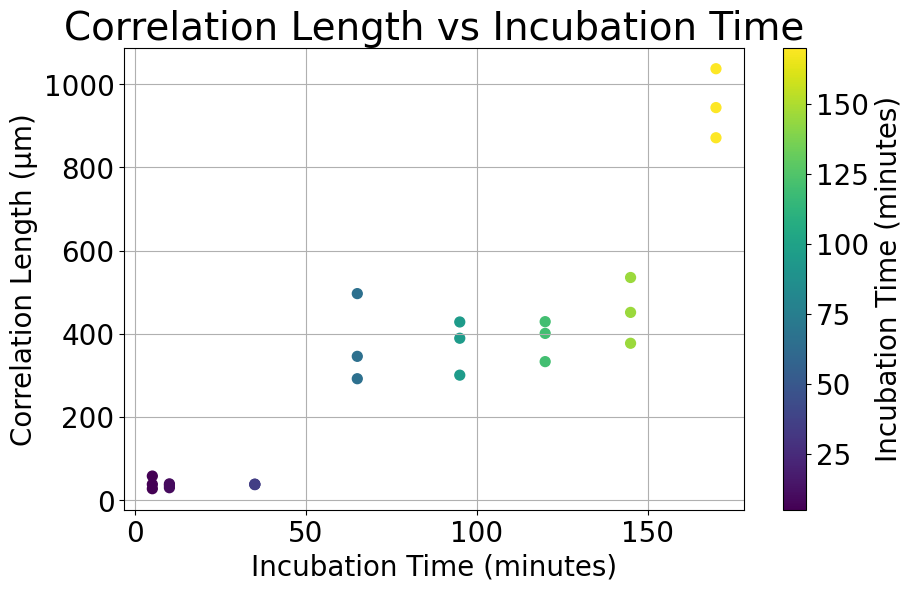

In [19]:
def exp_decay(x, A, l):
    return A * np.exp(-x / l)

def fit_correlation(distances, correlation):
    # Use only the positive part of the correlation
    positive_mask = correlation > 0
    x = distances[positive_mask]
    y = correlation[positive_mask]
    
    # Perform the fit
    try:
        popt, _ = curve_fit(exp_decay, x, y, p0=[1, 100], bounds=([0, 0], [1, np.inf]))
        return popt[1]  # Return the characteristic length
    except:
        return np.nan  # Return NaN if fitting fails

# Assuming you have your data in incubation_times and all_correlations lists
incubation_times = list(incubation_times)
data_pairs = list(zip(incubation_times, all_correlations))
sorted_data = sorted(data_pairs, key=lambda x: x[0])
incubation_times, all_correlations = zip(*sorted_data)

# Set up the colormap
norm = Normalize(vmin=min(incubation_times), vmax=max(incubation_times))
cmap = plt.get_cmap('viridis')

# Plotting the Velocity Correlation Function
plt.figure(figsize=(12, 8))

correlation_lengths = []

for time, correlation in zip(incubation_times, all_correlations):
    distances = np.arange(len(correlation)) * 0.43 * 30  # µm
    
    corr_length = fit_correlation(distances, correlation)
    correlation_lengths.append(corr_length)
    
    color = cmap(norm(time))
    plt.plot(distances, correlation, color=color, alpha=0.5)
    
    # Plot the fitted curve
    if not np.isnan(corr_length):
        fitted_curve = exp_decay(distances, 1, corr_length)
        plt.plot(distances, fitted_curve, color=color, linestyle='--', 
                 label=f'{time} min (L_c = {corr_length:.2f} µm)')

plt.xlabel('Distance (µm)')
plt.ylabel('Correlation Coefficient')
plt.title('Velocity Correlation Function for Different Incubation Times')
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Incubation Time (minutes)')
plt.tight_layout()
plt.show()

# Print correlation lengths
for time, length in zip(incubation_times, correlation_lengths):
    print(f"Incubation time: {time} min, Correlation length: {length:.2f} µm")

# Plotting Correlation Length vs Incubation Time
plt.figure(figsize=(10, 6))
scatter = plt.scatter(incubation_times, correlation_lengths, c=incubation_times, cmap='viridis', norm=norm, s=50)
plt.colorbar(scatter, label='Incubation Time (minutes)')
plt.xlabel('Incubation Time (minutes)')
plt.ylabel('Correlation Length (µm)')
plt.title('Correlation Length vs Incubation Time')
plt.grid(True)
plt.show()

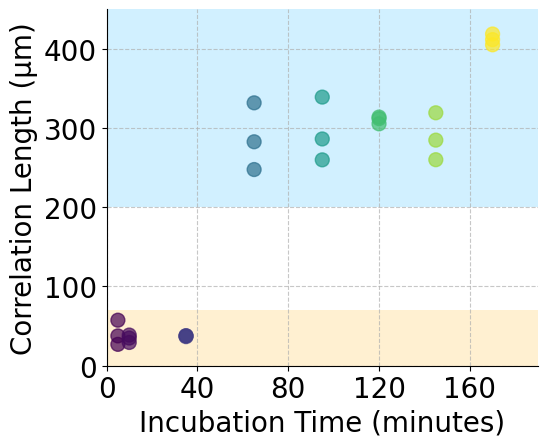

In [20]:


def set_plot_style():
    plt.rc('font', size=24)          # controls default text sizes
    plt.rc('axes', titlesize=28)    # fontsize of the axes title
    plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
    plt.rc('legend', fontsize=22)    # legend fontsize
    plt.rc('figure', titlesize=22)   # fontsize of the figure title
    return {
        'FIGURE_WIDTH': 6,
        'FIGURE_HEIGHT': 5,
        'SCATTER_SIZE': 100,
        'SCATTER_ALPHA': 0.7,
        'LINE_WIDTH': 2
    }


def exp_decay(x, A, l):
    return A * np.exp(-x / l)

def fit_correlation(distances, correlation):
    # Use only the positive part of the correlation
    positive_mask = correlation > 0
    x = distances[positive_mask]
    y = correlation[positive_mask]
    
    # Perform the fit
    try:
        popt, _ = curve_fit(exp_decay, x, y, p0=[1, 100], bounds=([0, 0], [1, np.inf]))
        return popt[1]  # Return the characteristic length
    except:
        return np.nan  # Return NaN if fitting fails

def calculate_correlation_length(distances, correlation, threshold=1/np.e, min_threshold=0.1):
    below_threshold = np.where(correlation < threshold)[0]
    if len(below_threshold) > 0:
        index = below_threshold[0]
        if index > 0:
            x = [distances[index-1], distances[index]]
            y = [correlation[index-1], correlation[index]]
            f = interp1d(y, x)
            return float(f(threshold))
    
    below_min = np.where(correlation < min_threshold)[0]
    if len(below_min) > 0:
        return distances[below_min[0]]
    
    return distances[-1]

style_params = set_plot_style()

# Calculate correlation lengths using the appropriate method based on incubation time
correlation_lengths = []
for time, correlation in zip(incubation_times, all_correlations):
    distances = np.arange(len(correlation)) * 0.43 * 30  # µm
    if time <= 40:
        corr_length = fit_correlation(distances, correlation)
    else:
        corr_length = calculate_correlation_length(distances, correlation)
    correlation_lengths.append(corr_length)

# Plotting
fig, ax = plt.subplots(figsize=(style_params['FIGURE_WIDTH'], style_params['FIGURE_HEIGHT']))

max_x = max(incubation_times) + 20

# Add shading
ax.add_patch(Rectangle((0, 0), max_x, 70, facecolor='#FFE6B3', alpha=0.6, zorder=0))
ax.add_patch(Rectangle((0, 200), max_x, 600, facecolor='#B3E6FF', alpha=0.6, zorder=0))

# Plot data points
scatter = ax.scatter(incubation_times, correlation_lengths, 
                     c=incubation_times, cmap='viridis', 
                     norm=Normalize(vmin=min(incubation_times), vmax=max(incubation_times)), 
                     s=style_params['SCATTER_SIZE'], 
                     alpha=style_params['SCATTER_ALPHA'], zorder=2)

ax.set_xlabel('Incubation Time (minutes)')
ax.set_ylabel('Correlation Length (µm)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, linestyle='--', alpha=0.7)

ax.set_xlim(left=0, right=max_x)
ax.set_ylim(bottom=0, top=450)
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True, nbins=5))

plt.tight_layout()
plt.show()

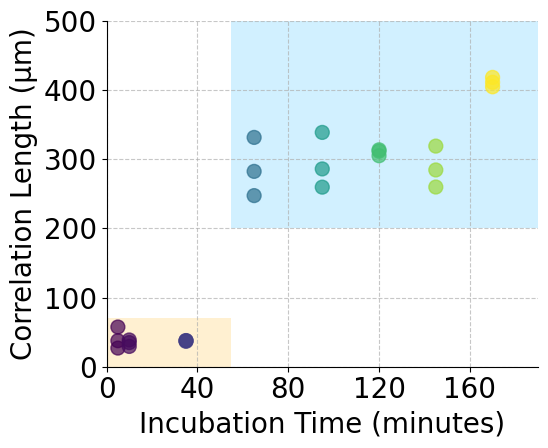

In [21]:
fig, ax = plt.subplots(figsize=(style_params['FIGURE_WIDTH'], style_params['FIGURE_HEIGHT']))

max_x = max(incubation_times) + 20

# Add shading
ax.add_patch(Rectangle((0, 0), 55, 70, facecolor='#FFE6B3', alpha=0.6, zorder=0))  # Yellow region up to 50 minutes
ax.add_patch(Rectangle((55, 200), max_x - 55, 400, facecolor='#B3E6FF', alpha=0.6, zorder=0))  # Blue region starting from 50 minutes

# Plot data points
scatter = ax.scatter(incubation_times, correlation_lengths, 
                     c=incubation_times, cmap='viridis', 
                     norm=Normalize(vmin=min(incubation_times), vmax=max(incubation_times)), 
                     s=style_params['SCATTER_SIZE'], 
                     alpha=style_params['SCATTER_ALPHA'], zorder=2)

ax.set_xlabel('Incubation Time (minutes)')
ax.set_ylabel('Correlation Length (µm)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, linestyle='--', alpha=0.7)

ax.set_xlim(left=0, right=max_x)
ax.set_ylim(bottom=0, top=500)
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True, nbins=5))

plt.tight_layout()
plt.show()

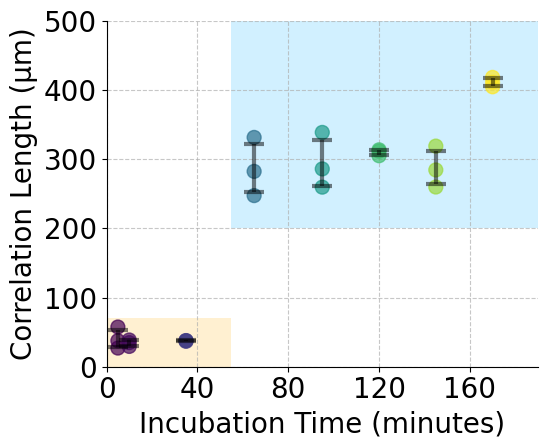

In [22]:
fig, ax = plt.subplots(figsize=(style_params['FIGURE_WIDTH'], style_params['FIGURE_HEIGHT']))

max_x = max(incubation_times) + 20

# Add shading
ax.add_patch(Rectangle((0, 0), 55, 70, facecolor='#FFE6B3', alpha=0.6, zorder=0))
ax.add_patch(Rectangle((55, 200), max_x - 55, 400, facecolor='#B3E6FF', alpha=0.6, zorder=0))

# Calculate mean and standard deviation for each unique incubation time
unique_times = np.unique(incubation_times)
mean_lengths = []
std_lengths = []

for time in unique_times:
    lengths = [l for t, l in zip(incubation_times, correlation_lengths) if t == time]
    mean_lengths.append(np.mean(lengths))
    std_lengths.append(np.std(lengths))

# Plot all data points
scatter = ax.scatter(incubation_times, correlation_lengths, 
                     c=incubation_times, cmap='viridis', 
                     norm=Normalize(vmin=min(incubation_times), vmax=max(incubation_times)), 
                     s=style_params['SCATTER_SIZE'], 
                     alpha=style_params['SCATTER_ALPHA'], zorder=2)

# Plot thicker error bars representing standard deviation
ax.errorbar(unique_times, mean_lengths, yerr=std_lengths, 
            fmt='none', ecolor=(0, 0, 0, 0.5), capsize=7, 
            elinewidth=3, capthick=3, zorder=3)

ax.set_xlabel('Incubation Time (minutes)')
ax.set_ylabel('Correlation Length (µm)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, linestyle='--', alpha=0.7)

ax.set_xlim(left=0, right=max_x)
ax.set_ylim(bottom=0, top=500)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True, nbins=5))

plt.tight_layout()
plt.show()